In [4]:
# ==============================================================================
# CELL 1: SETUP AND IMPORTS
# ==============================================================================
import os
import shutil
import random
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import kagglehub

print("All libraries imported successfully.")


All libraries imported successfully.


In [5]:
# ==============================================================================
# CELL 2: DOWNLOAD AND PREPARE DATASET
# ==============================================================================
# --- Download from Kaggle ---
print("Downloading dataset from Kaggle Hub...")
path = kagglehub.dataset_download("mrnotalent/braint")
print(f"Path to dataset files: {path}")

# --- Copy to a writable directory ---
# This is necessary as the Kaggle input directory is read-only
src = path
dst = '/content/braint_original'
shutil.copytree(src, dst, dirs_exist_ok=True)
print(f"Dataset copied to {dst}")

Path to dataset files: /kaggle/input/braint
Dataset copied to /content/braint_original


In [6]:
# ==============================================================================
# CELL 3: CREATE TRAIN / VALIDATION / TEST SPLIT
# ==============================================================================
# --- Step A: Define paths and create the new directory structure ---
original_base_dir = '/content/braint_original'
new_base_dir = '/content/data'

class_names = [d for d in os.listdir(original_base_dir) if os.path.isdir(os.path.join(original_base_dir, d))]
print(f"Found {len(class_names)} classes: {class_names[:5]}...") # Print first 5 classes

# Create train/val/test directories
for split in ['train', 'val', 'test']:
    for class_name in class_names:
        os.makedirs(os.path.join(new_base_dir, split, class_name), exist_ok=True)

# --- Step B: Gather all file paths and labels ---
all_files = []
for class_name in class_names:
    class_dir = os.path.join(original_base_dir, class_name)
    for fname in os.listdir(class_dir):
        if os.path.isfile(os.path.join(class_dir, fname)):
            all_files.append({'path': os.path.join(class_dir, fname), 'label': class_name})

df = pd.DataFrame(all_files)

# --- Step C: Stratified split into train, validation, and test sets ---
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df['label'])

print(f"\nTotal images: {len(df)}")
print(f"Training size: {len(train_df)} (70%)")
print(f"Validation size: {len(val_df)} (15%)")
print(f"Test size: {len(test_df)} (15%)")

# --- Step D: Copy files into the new directories ---
def copy_files(dataframe, split_name):
    for _, row in dataframe.iterrows():
        src_path = row['path']
        dst_path = os.path.join(new_base_dir, split_name, row['label'], os.path.basename(src_path))
        shutil.copy(src_path, dst_path)
    print(f"Finished copying {split_name} files.")

copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')
print("\nData splitting and structuring complete.")

Found 44 classes: ['Astrocitoma T1', 'Meduloblastoma T1C+', 'Ganglioglioma T2', 'Germinoma T1', 'Oligodendroglioma T2']...

Total images: 16236
Training size: 11365 (70%)
Validation size: 2435 (15%)
Test size: 2436 (15%)
Finished copying train files.
Finished copying val files.
Finished copying test files.

Data splitting and structuring complete.


In [7]:
# ==============================================================================
# CELL 4: DEFINE TRANSFORMS AND DATALOADERS
# ==============================================================================
IMG_SIZE = 224 # GoogLeNet expects at least 224x224 inputs

# --- Define conservative medical image augmentations ---
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomApply([transforms.RandomRotation(degrees=10)], p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1)], p=0.3),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0]==1 else t), # Handle grayscale
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0]==1 else t),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- Create Datasets and DataLoaders ---
data_dir = '/content/data'
train_ds = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_tfms)
val_ds = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_tfms)
test_ds = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("\nDataLoaders are ready.")


DataLoaders are ready.


In [8]:
# ==============================================================================
# CELL 5: DEFINE THE GOOGLENET MODEL
# ==============================================================================
def get_googlenet_model(num_classes, pretrained=True, freeze_backbone=True):
    """
    Initializes a pretrained GoogLeNet model, replaces the classifier,
    and optionally freezes the backbone layers.
    """
    # Load pretrained GoogLeNet
    weights = models.GoogLeNet_Weights.IMAGENET1K_V1 if pretrained else None
    model = models.googlenet(weights=weights, aux_logits=True)

    # Freeze backbone layers if specified
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)

    return model

print("GoogLeNet model function defined.")

GoogLeNet model function defined.


In [9]:
# ==============================================================================
# CELL 6: TRAINING AND EVALUATION LOOP
# ==============================================================================
# --- Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_googlenet_model(num_classes=len(class_names), pretrained=True, freeze_backbone=True).to(device)

criterion = nn.CrossEntropyLoss()
# Initially, only optimize the parameters of the newly added classifier
optimizer = optim.AdamW(model.fc.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

# --- Training and Evaluation Functions ---
def train_one_epoch():
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()

        # GoogLeNet returns main and auxiliary outputs in train mode
        outputs = model(x)
        loss1 = criterion(outputs.logits, y)
        loss2 = criterion(outputs.aux_logits2, y)
        loss = loss1 + 0.4 * loss2 # Combine main and auxiliary loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()*x.size(0)
        # Accuracy is calculated on the main output
        pred = outputs.logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

@torch.no_grad()
def evaluate(loader):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        # In eval mode, GoogLeNet returns only the final output
        logits = model(x)
        loss = criterion(logits, y)
        running_loss += loss.item()*x.size(0)
        pred = logits.argmax(1)
        correct += (pred==y).sum().item()
        total += x.size(0)
    return running_loss/total, correct/total

# --- Main Training Loop ---
EPOCHS = 20
best_acc, best_path = 0.0, "googlenet_brain_tumor_best.pth"
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

print(f"Starting training for {EPOCHS} epochs on {device}...")
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_one_epoch()
    va_loss, va_acc = evaluate(val_loader)
    scheduler.step()

    train_losses.append(tr_loss)
    train_accuracies.append(tr_acc)
    val_losses.append(va_loss)
    val_accuracies.append(va_acc)

    print(f"Epoch {epoch:02d} | Train Loss {tr_loss:.4f} Acc {tr_acc:.4f} | Val Loss {va_loss:.4f} Acc {va_acc:.4f}")

    if epoch == 5:
        print("→ Unfreezing backbone for fine-tuning...")
        for p in model.parameters(): p.requires_grad = True
        # Create a new optimizer that includes all parameters
        optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
        scheduler = CosineAnnealingLR(optimizer, T_max=15)

    if va_acc > best_acc:
        best_acc = va_acc
        torch.save({"state_dict": model.state_dict(), "classes": train_ds.classes}, best_path)
        print(f"✓ Saved new best model to {best_path} (val acc {best_acc:.4f})")

print(f"\nFinished Training. Best Validation Accuracy: {best_acc:.4f}")

# --- Final Evaluation on Test Set ---
print("\nPerforming final evaluation on the unseen test set...")
model.load_state_dict(torch.load(best_path)["state_dict"])
test_loss, test_acc = evaluate(test_loader)
print(f"FINAL TEST RESULTS -> Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 194MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/googlenet.py:341: UserWarning: auxiliary heads in the pretrained googlenet model are NOT pretrained, so make sure to train them
  warnings.warn(


Starting training for 20 epochs on cuda...
Epoch 01 | Train Loss 6.3892 Acc 0.1638 | Val Loss 2.9941 Acc 0.2936
✓ Saved new best model to googlenet_brain_tumor_best.pth (val acc 0.2936)
Epoch 02 | Train Loss 5.8301 Acc 0.3170 | Val Loss 2.6061 Acc 0.3889
✓ Saved new best model to googlenet_brain_tumor_best.pth (val acc 0.3889)
Epoch 03 | Train Loss 5.5408 Acc 0.3786 | Val Loss 2.3900 Acc 0.4172
✓ Saved new best model to googlenet_brain_tumor_best.pth (val acc 0.4172)
Epoch 04 | Train Loss 5.3610 Acc 0.4217 | Val Loss 2.2248 Acc 0.4485
✓ Saved new best model to googlenet_brain_tumor_best.pth (val acc 0.4485)
Epoch 05 | Train Loss 5.2516 Acc 0.4343 | Val Loss 2.1480 Acc 0.4682
→ Unfreezing backbone for fine-tuning...
✓ Saved new best model to googlenet_brain_tumor_best.pth (val acc 0.4682)
Epoch 06 | Train Loss 2.9295 Acc 0.6053 | Val Loss 0.9507 Acc 0.7478
✓ Saved new best model to googlenet_brain_tumor_best.pth (val acc 0.7478)
Epoch 07 | Train Loss 1.5586 Acc 0.8103 | Val Loss 0.5822 

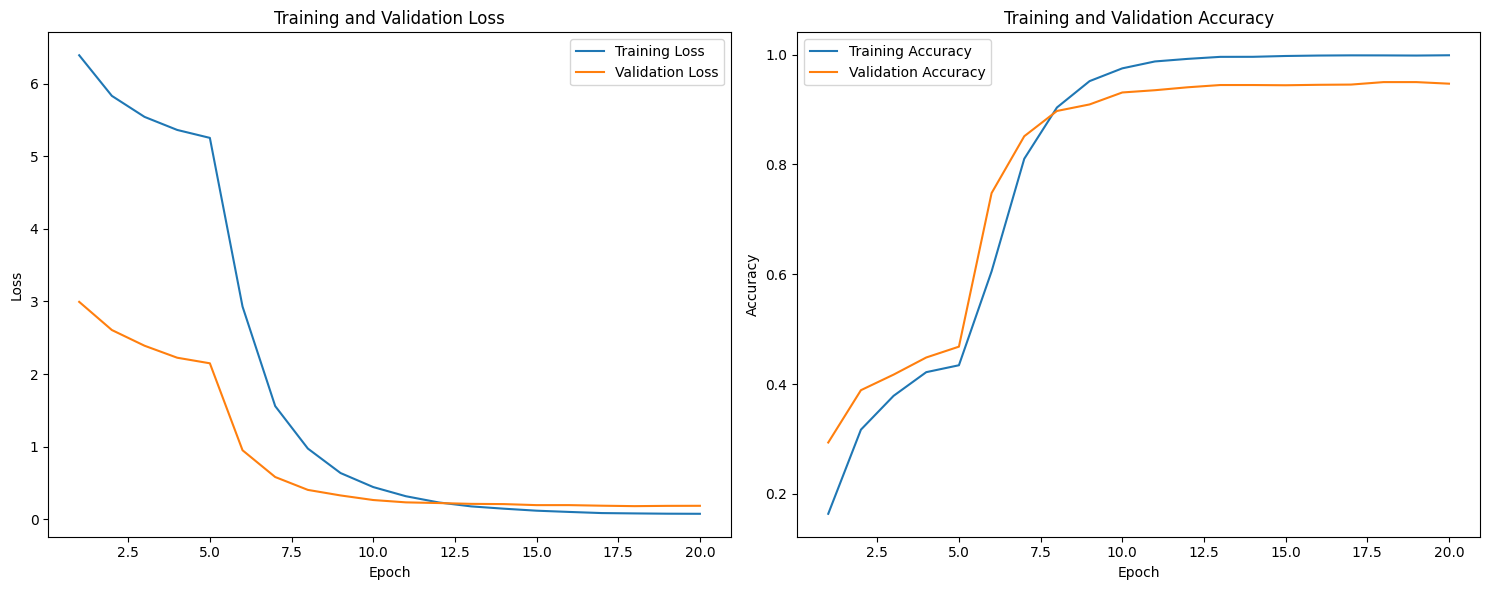

In [10]:
# ==============================================================================
# CELL 7: PLOT TRAINING HISTORY
# ==============================================================================
plt.figure(figsize=(15, 6))
epochs_range = range(1, EPOCHS + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Generating final report and confusion matrix on the TEST SET...

Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1     0.9153    0.9643    0.9391        56
      Astrocitoma T1C+     0.9804    0.8929    0.9346        56
        Astrocitoma T2     0.9767    0.7500    0.8485        56
          Carcinoma T1     0.9636    0.9636    0.9636        55
        Carcinoma T1C+     0.9800    0.8909    0.9333        55
          Carcinoma T2     0.9815    0.9636    0.9725        55
         Ependimoma T1     0.9322    1.0000    0.9649        55
       Ependimoma T1C+     0.9167    1.0000    0.9565        55
         Ependimoma T2     0.9815    0.9636    0.9725        55
      Ganglioglioma T1     1.0000    1.0000    1.0000        56
    Ganglioglioma T1C+     0.9483    1.0000    0.9735        55
      Ganglioglioma T2     0.9483    0.9821    0.9649        56
          Germinoma T1     1.0000    1.0000    1.0000        55
        Germin

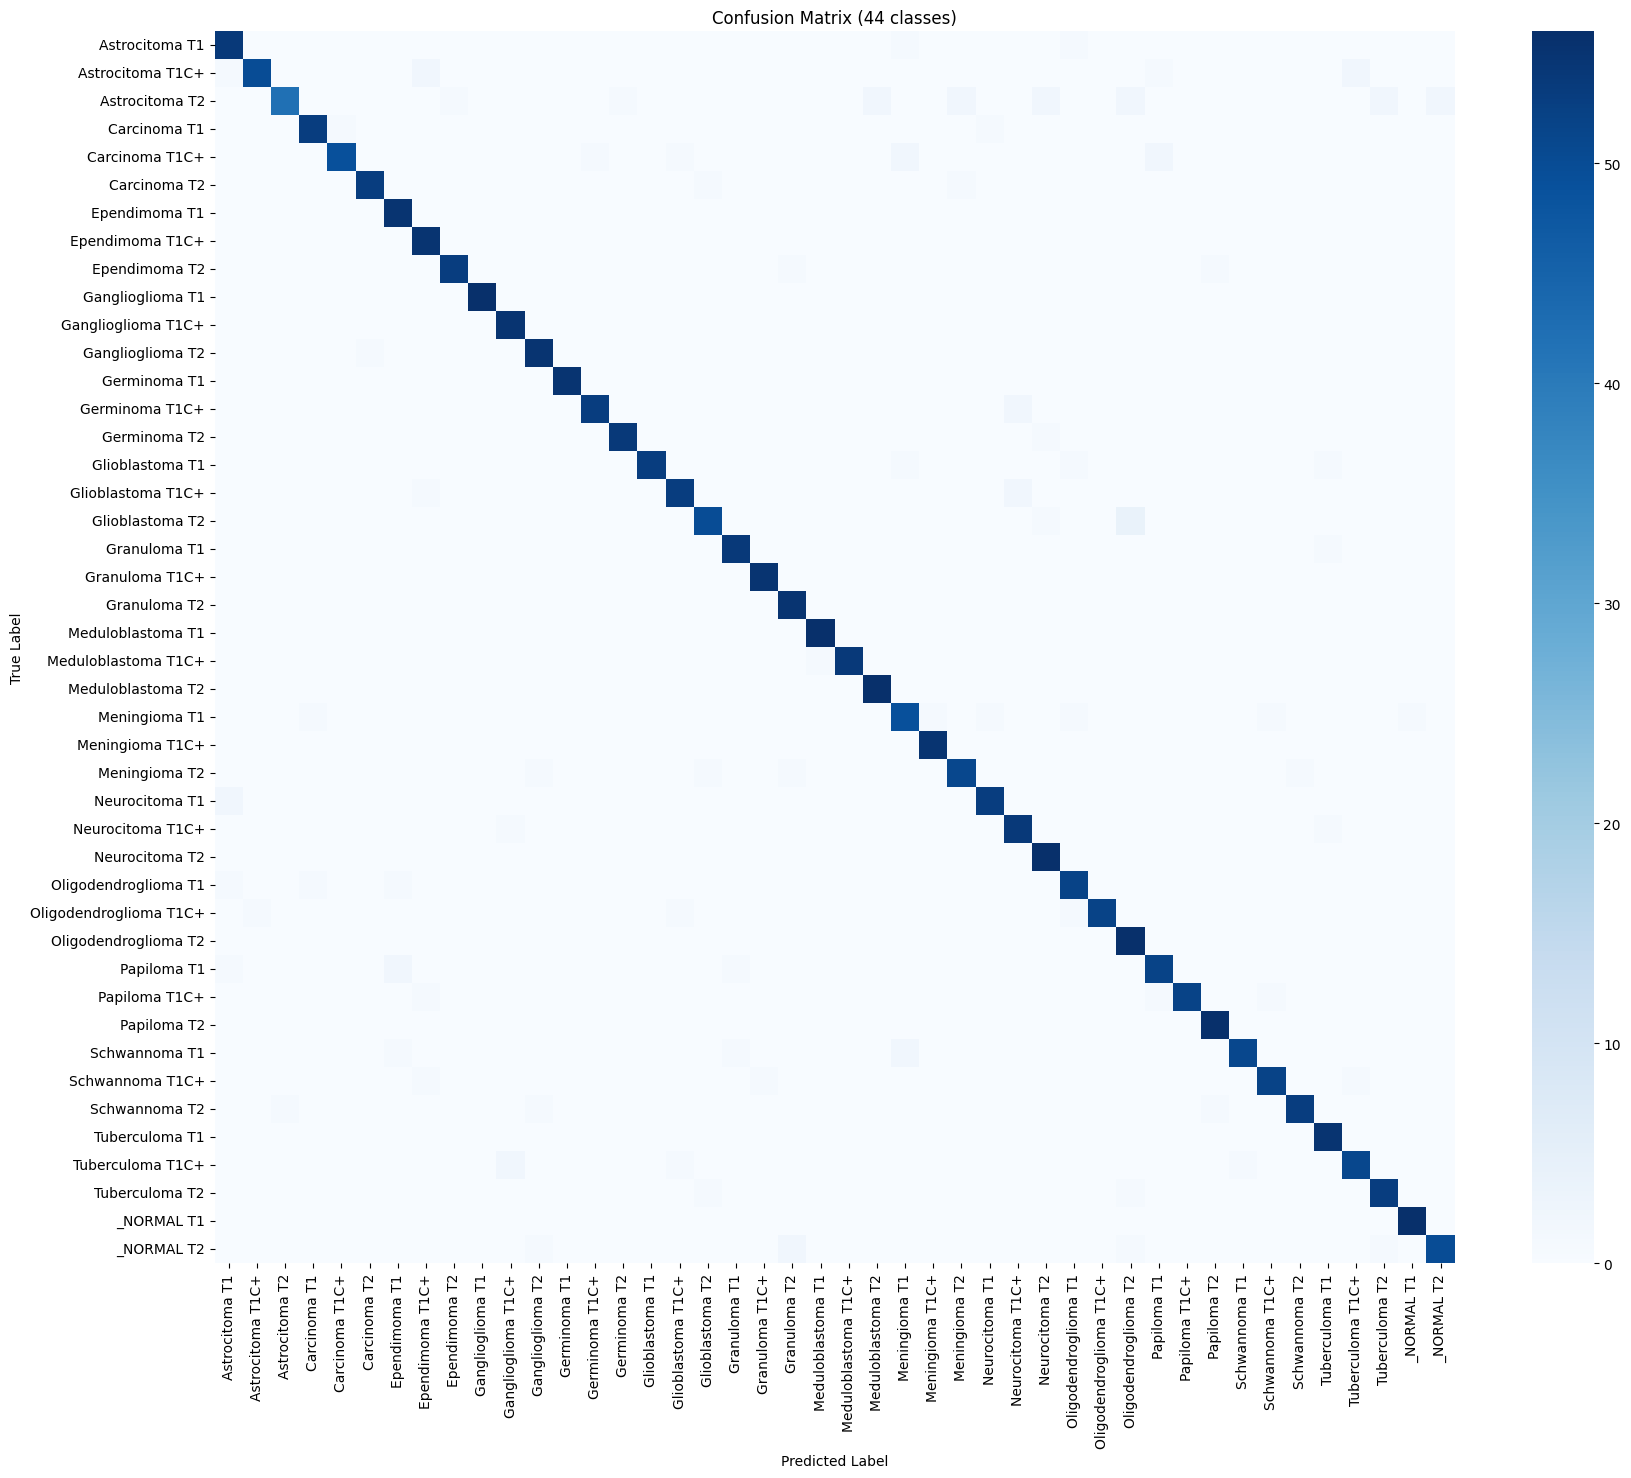

In [11]:
# ==============================================================================
# CELL 8: DETAILED REPORT AND CONFUSION MATRIX ON TEST SET
# ==============================================================================
print("\nGenerating final report and confusion matrix on the TEST SET...")
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=test_ds.classes, digits=4))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=test_ds.classes, yticklabels=test_ds.classes)
plt.title(f"Confusion Matrix ({len(test_ds.classes)} classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


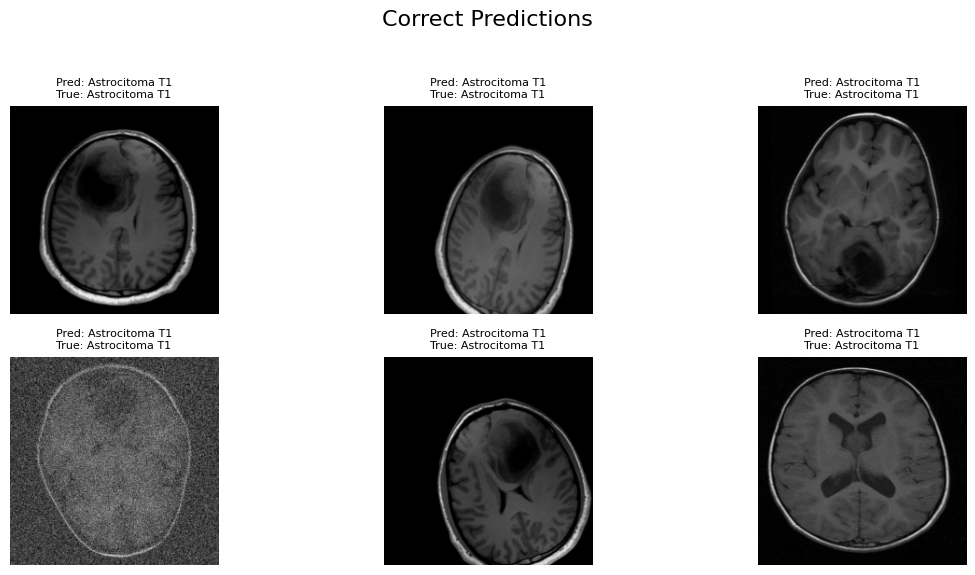

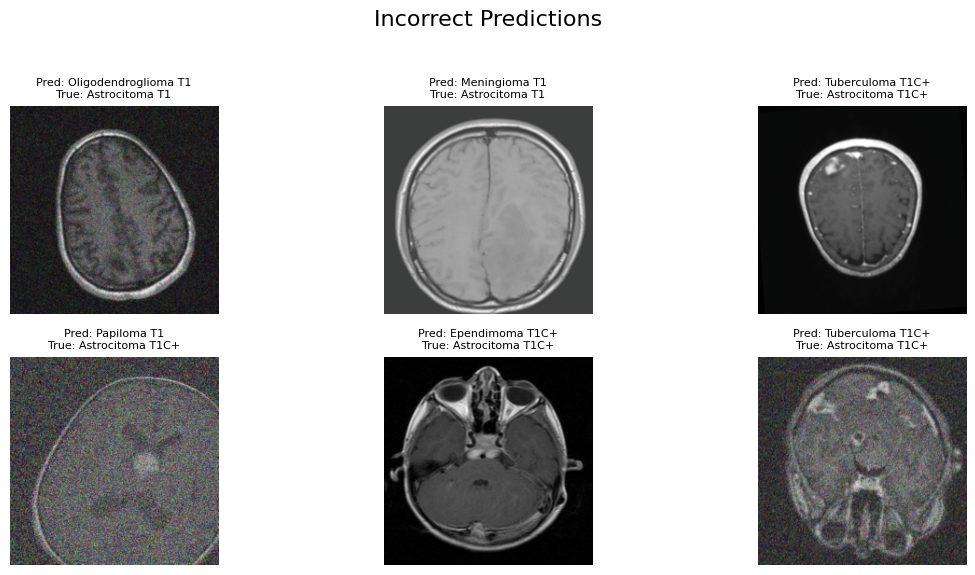

In [12]:
# ==============================================================================
# CELL 9: QUALITATIVE ANALYSIS (ERROR VISUALIZATION)
# ==============================================================================
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean, std = np.array([0.485, 0.456, 0.406]), np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=8)
    plt.axis('off')

correct_samples, incorrect_samples = [], []
num_to_show = 6

# Use a temporary dataloader without shuffling to get consistent samples
temp_test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

with torch.no_grad():
    for images, labels in temp_test_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        for i in range(images.size(0)):
            if len(correct_samples) < num_to_show and preds[i] == labels[i].to(device):
                correct_samples.append({'image': images[i], 'pred': preds[i].item(), 'true': labels[i].item()})
            elif len(incorrect_samples) < num_to_show and preds[i] != labels[i].to(device):
                incorrect_samples.append({'image': images[i], 'pred': preds[i].item(), 'true': labels[i].item()})
        if len(correct_samples) >= num_to_show and len(incorrect_samples) >= num_to_show:
            break

# --- Plot Correct Predictions ---
fig = plt.figure(figsize=(12, 6))
plt.suptitle("Correct Predictions", fontsize=16)
for i, sample in enumerate(correct_samples):
    ax = plt.subplot(2, 3, i + 1)
    title = f"Pred: {test_ds.classes[sample['pred']]}\nTrue: {test_ds.classes[sample['true']]}"
    imshow(sample['image'], title=title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Plot Incorrect Predictions ---
fig = plt.figure(figsize=(12, 6))
plt.suptitle("Incorrect Predictions", fontsize=16)
for i, sample in enumerate(incorrect_samples):
    ax = plt.subplot(2, 3, i + 1)
    title = f"Pred: {test_ds.classes[sample['pred']]}\nTrue: {test_ds.classes[sample['true']]}"
    imshow(sample['image'], title=title)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
